### A notebook to normalize the orientation of the centriole 

This normalization occur on a data_Laoder

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from numba import jit

import numpy as np
import csv
import pickle
import import_ipynb

import random

In [2]:
def dataset_loader(path = '../data/', train_set = 'train_data_pregression_b700_unNormalized.pth', val_set = 'validation_loader_dataset_b700_unNormalized.pth' ):
    """ A function that load a 'torch' dataset.
    Arguments:
        -> path    : path to the dataset location
        -> train_set: name of the train dataset
        -> val_set  : name of the validation dataset
    """
    train_loader = pickle.load(open(path + train_set, 'rb'))
    validation_loader = pickle.load(open(path + val_set, 'rb'))
    
    return train_loader, validation_loader

In [3]:
class centriole_dataset(Dataset):
    def __init__(self, img_db, angle_db, transform = None, root_dir = None, problem = None):
        self.root_dir = root_dir
        self.img_db = img_db
        self.angle_db = angle_db
        self.transform = transform
        self.problem = problem
           
    def __len__(self):
        return len(self.angle_db)
    
    def __getitem__(self, idx):
        
        img = self.img_db[idx]
        angle = self.angle_db[idx]
        
        if self.problem == 'classification':
            angle = np.array(angle, dtype = 'int') # [angle]
        else:
            angle = np.array(angle, dtype = 'double')
        
        sample = {'image': img, 'angle': angle}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [4]:
train_loaded = pickle.load(open('./data/train_data_pclassification_n360_b700_.pth', 'rb'))

importing Jupyter notebook from /home/cyril_b/projects/Planarians/tools/Dataset_Tools.ipynb
importing Jupyter notebook from /home/cyril_b/projects/Planarians/tools/ToolBox.ipynb


In [10]:
img_db = []
angle_db = []
maxAngle = 0
n_class = 360

#@jit(nopython=False)
def centriole_reorientation(dataset, nClass):
    angleTol = 360/nClass
    
    for data in dataset:
        for i in range(len(data['angle'])):
        #for i in range(10):
            # Search the number of 90 deg rotation to put the centriole in an 0-90° range
            rotation = (data['angle'][i].numpy()//(angleTol))//(nClass/4)*90
            newAngle = data['angle'][i].numpy()-rotation


            # Re orient the image in a 0-90° range
            i = 0
            image = data['image'][i].numpy()
            while i != rotation/90:
                image = np.rot90(image)
                i += 1

            # Randomly reorient the image and adjust the angle
            i = 0
            rd_rot = random.randint(0,3)
            newAngle = rd_rot*90 + newAngle
            
            while i != rd_rot:
                image = np.rot90(image)
                i += 1


            #if newAngle//angleTol == 0 or newAngle//angleTol == 18 or newAngle//angleTol == 36 or newAngle//angleTol == 54:
            #    if random.random() < 0.66:      
            #        img_db.append(image)
            #        angle_db.append(newAngle)
            #else: 
            #    img_db.append(image)
            #    angle_db.append(newAngle)
            img_db.append(image)
            angle_db.append(newAngle)
    
    return img_db, angle_db
        
img_db, angle_db = centriole_reorientation(train_loaded, 360)
print('Computation over')

Computation over


In [11]:
newDB = []

for i in img_db:
    flat = i.flatten()
    flat = flat.reshape(1,32,32)
    newDB.append(flat)
    
newDB = np.array(newDB, dtype='double')
newDB = newDB.reshape(len(img_db), 1, 32, 32)

In [12]:
angle_db = np.array(angle_db)

training = centriole_dataset(newDB, angle_db, problem = 'classification')

train_loader = torch.utils.data.DataLoader(training, batch_size = 700, shuffle = True, drop_last=True)

In [14]:

with open('./data/data_train_pclassification_n360_b700_normalized.pth', 'wb') as f:
    pickle.dump(train_loader, f, protocol = 4)

#pickle.dump(train_loader, open('./data/data_train_regression_normalized_2.pth', 'wb'), protocol=4)

<AxesSubplot:ylabel='Count'>

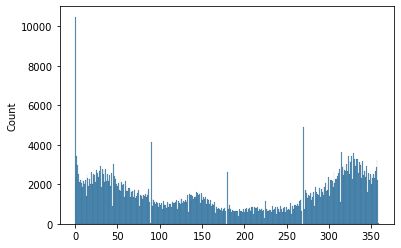

In [15]:
# Old Distribution
nClass = 360

class_ = np.zeros(nClass)
classes = np.linspace(0,nClass-1, nClass, dtype = np.int16)

for i in train_loaded:
    for j in i['angle']:
        class_[int(j.numpy()//(360/nClass))] += 1
        
import seaborn as sns

sns.histplot(x = classes, weights = class_, discrete =  True)

<AxesSubplot:ylabel='Count'>

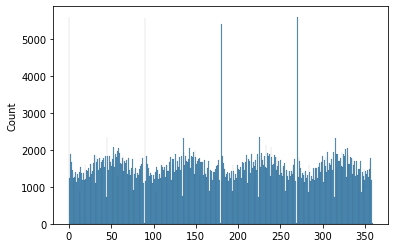

In [16]:
# New Distribution

nClass = 360

class_ = np.zeros(nClass)
classes = np.linspace(0,nClass-1, nClass, dtype = np.int16)

for i in train_loader:
    for j in i['angle']:
        class_[int(j.numpy()//(360/nClass))] += 1
        
import seaborn as sns

sns.histplot(x = classes, weights = class_, discrete =  True)

In [ ]:
from PIL import Image
import numpy as np

import random

In [ ]:
raw_img = []
raw_angle = []
for i in train_loaded:
    for j in range(len(i['image'])):
        raw_img.append(i['image'][j].numpy())
        raw_angle.append(i['angle'][j])

In [ ]:
i = random.randint(0, len(raw_angle))
test_angle = raw_angle[i]
test_img = raw_img[i].reshape(32, 32)

test_img = test_img/np.amax(test_img)

print(test_angle.numpy())

# Creates PIL image
img = Image.fromarray(np.uint8(test_img * 255) , 'L')
img.show()